# Plot Utilization and Network Use over Time
Give an idea about how much our app uses multiple resources and the network

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

Configuration

In [2]:
colors = {
    'inference': 'deepskyblue',
    'simulation': 'goldenrod',
    'training': 'maroon',
}

## Import Data
We're going to use the utilization data from the baseline, Parsl-only application because it's easier to track what's happening

In [3]:
utilization = pd.read_csv('prod-runs/8KNL-20T4-no-ps/processed-results/utilization.csv')
utilization.head()

,task_type,timestamp,machine,hostname,change,walltime,venti,theta,training,simulation,inference,total,time_queueing
0,training,1.677896e+09,venti,venti,1,0.000000,1,0,1,0,0,1,0.0
1,training,1.677896e+09,venti,venti,1,0.000010,2,0,2,0,0,2,0.0
2,training,1.677896e+09,venti,venti,1,0.000011,3,0,3,0,0,3,0.0
3,training,1.677896e+09,venti,venti,1,0.000027,4,0,4,0,0,4,0.0
4,training,1.677896e+09,venti,venti,1,0.000054,5,0,5,0,0,5,0.0


In [4]:
all_tasks = pd.read_csv('prod-runs/8KNL-20T4-no-ps/processed-results/all-tasks.csv').sort_values('walltime')
all_tasks.head()

,task_id,method,success,task_info,resources,failure_info,worker_info,time_created,time_input_received,time_compute_started,...,proxystore_threshold,inputs,task,hostname,machine,task_type,walltime,time_queueing,theta_usage,venti_usage
5,73e50667-cef6-47ba-9fcf-4582fef14a37,retrain_mpnn,True,{'model_id': 3},"{'node_count': 1, 'cpu_processes': 1, 'cpu_thr...",NaN,"{'hostname': 'venti', 'PARSL_WORKER_RANK': '2'...",1.677896e+09,1.677896e+09,1.677896e+09,...,NaN,NaN,training,venti,venti,training,140.035751,0.0,0.0,0.000796
8,2eb6bd1d-3546-43cc-8349-96d05663e9f0,evaluate_mpnn,True,"{'chunk_id': 0, 'chunk_size': 48493, 'model_id...","{'node_count': 1, 'cpu_processes': 1, 'cpu_thr...",NaN,"{'hostname': 'venti', 'PARSL_WORKER_RANK': '10...",1.677896e+09,1.677896e+09,1.677896e+09,...,NaN,"[[], {}]",inference,venti,venti,inference,198.332007,0.0,0.0,0.324664
10,925d6c30-e1be-4659-9c34-162ca3183611,evaluate_mpnn,True,"{'chunk_id': 2, 'chunk_size': 48493, 'model_id...","{'node_count': 1, 'cpu_processes': 1, 'cpu_thr...",NaN,"{'hostname': 'venti', 'PARSL_WORKER_RANK': '11...",1.677896e+09,1.677896e+09,1.677896e+09,...,NaN,"[[], {}]",inference,venti,venti,inference,208.645188,0.0,0.0,0.381959
11,4c6c63ee-b8a3-4abe-9646-d2f7bb3fe738,evaluate_mpnn,True,"{'chunk_id': 3, 'chunk_size': 48493, 'model_id...","{'node_count': 1, 'cpu_processes': 1, 'cpu_thr...",NaN,"{'hostname': 'venti', 'PARSL_WORKER_RANK': '9'...",1.677896e+09,1.677896e+09,1.677896e+09,...,NaN,"[[], {}]",inference,venti,venti,inference,210.787074,0.0,0.0,0.393859
9,c4dc493a-e5aa-4d85-85cd-bb1ff7e1fd68,evaluate_mpnn,True,"{'chunk_id': 1, 'chunk_size': 48493, 'model_id...","{'node_count': 1, 'cpu_processes': 1, 'cpu_thr...",NaN,"{'hostname': 'venti', 'PARSL_WORKER_RANK': '8'...",1.677896e+09,1.677896e+09,1.677896e+09,...,NaN,"[[], {}]",inference,venti,venti,inference,210.790638,0.0,0.0,0.393878


## Compute the Amount of Data Moved at Each Timestep
We want the amount moved to each site over time

In [5]:
all_tasks['data_inputs'] = all_tasks['message_sizes'].apply(lambda x: eval(x).get('inputs'))

In [6]:
all_tasks['data_value'] = all_tasks['message_sizes'].apply(lambda x: eval(x).get('value'))

Add it to the utilization dataframe

In [7]:
def get_total_data_moved(timestamp: float, tasks: pd.DataFrame):
    """Gather how much data was moved before a certain timestamp
    
    Args:
        timestamp: Time at which to make measurement
        tasks: Subset of the tasks to consider
    Returns:
        How much data has been moved (units: bytes)
    """
    
    total_inputs = tasks[tasks['time_compute_started'] < timestamp]['data_inputs'].sum()
    total_values = tasks[tasks['time_result_received'] < timestamp]['data_value'].sum()
    return total_inputs + total_values

In [8]:
get_total_data_moved(utilization['timestamp'].iloc[50], all_tasks) / 1e6

2400.905475

Separate into CPU and GPU tasks

In [9]:
all_tasks['method'].value_counts()

evaluate_mpnn     1104
run_simulation     520
retrain_mpnn        56
Name: method, dtype: int64

In [10]:
gpu_tasks = all_tasks[all_tasks['method'].apply(lambda x: x in ['evaluate_mpnn', 'retrain_mpnn'])]
cpu_tasks = all_tasks[all_tasks['method'].apply(lambda x: x in ['run_simulation'])]
assert len(gpu_tasks) + len(cpu_tasks) == len(all_tasks)

Compute the data moved at each time

In [11]:
%%time
utilization['data_to_gpu'] = utilization['timestamp'].apply(lambda x: get_total_data_moved(x, gpu_tasks))

CPU times: user 1.42 s, sys: 12.4 ms, total: 1.43 s
Wall time: 1.42 s


In [12]:
utilization['data_to_cpu'] = utilization['timestamp'].apply(lambda x: get_total_data_moved(x, cpu_tasks))

## Plot CPU and GPU on Separate Subplots
So that we can show them more clearly

In [13]:
utilization

,task_type,timestamp,machine,hostname,change,walltime,venti,theta,training,simulation,inference,total,time_queueing,data_to_gpu,data_to_cpu
0,training,1.677896e+09,venti,venti,1,0.000000,1,0,1,0,0,1,0.000000,0,0
1,training,1.677896e+09,venti,venti,1,0.000010,2,0,2,0,0,2,0.000000,300583,0
2,training,1.677896e+09,venti,venti,1,0.000011,3,0,3,0,0,3,0.000000,601166,0
3,training,1.677896e+09,venti,venti,1,0.000027,4,0,4,0,0,4,0.000000,901725,0
4,training,1.677896e+09,venti,venti,1,0.000054,5,0,5,0,0,5,0.000000,1202308,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,training,1.677904e+09,venti,venti,-1,7441.781201,4,0,4,0,0,4,129.643073,115255379887,772530844
3356,training,1.677904e+09,venti,venti,-1,7475.697223,3,0,3,0,0,3,129.643073,115260681872,772530844
3357,training,1.677904e+09,venti,venti,-1,7483.894825,2,0,2,0,0,2,129.643073,115265985117,772530844
3358,training,1.677904e+09,venti,venti,-1,7572.192274,1,0,1,0,0,1,129.643073,115271288488,772530844


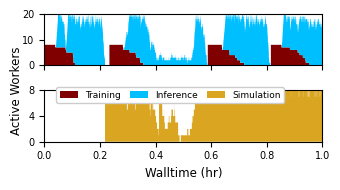

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.), sharex=True, sharey=False)

# Plot the CPU tasks
ax = axs[1]
task_types = ['simulation']
for i, task_type in enumerate(task_types):
    other_types = utilization[task_types[:i]].sum(axis=1)
    ax.fill_between(utilization['walltime'] / 3600, other_types, utilization[task_type] + other_types, 
                    color=colors[task_type], edgecolor='none',
                    step='post', label=task_type.capitalize())
ax.set_ylabel('Active Workers', y=1, horizontalalignment='center')
ax.set_ylim([0, 8])
ax.set_yticks([0, 4, 8])

    
# Plot the GPU tasks
ax = axs[0]
task_types = ['training', 'inference']
for i, task_type in enumerate(task_types):
    other_types = utilization[task_types[:i]].sum(axis=1)
    ax.fill_between(utilization['walltime'] / 3600, other_types, utilization[task_type] + other_types,
                    color=colors[task_type], edgecolor='none',
                    step='post', label=task_type.capitalize())
ax.set_ylim(0, 20)

# Plot the axes
axs[1].set_xlabel('Walltime (hr)')
axs[1].set_xlim(0, 1)
fig.legend(ncol=4, loc='center', bbox_to_anchor=[0.5, 0.5], fontsize=6.5, columnspacing=1, framealpha=1)

fig.tight_layout()
fig.savefig('figures/resource-utilization.png')

## Plot the Data Movement
As it's own separate plot

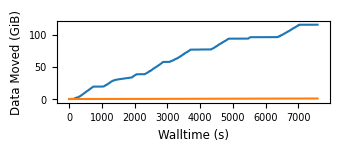

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 1.5))

ax.plot(utilization['walltime'], utilization['data_to_gpu'] / 1e9, label='GPU')
ax.plot(utilization['walltime'], utilization['data_to_cpu'] / 1e9, label='CPU')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Data Moved (GiB)')

fig.tight_layout()

## A combined plot
To save space

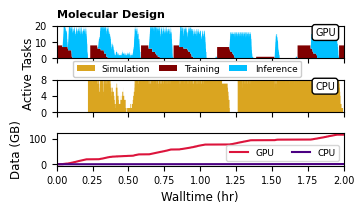

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 2.), sharex=True, sharey=False)

fig.subplots_adjust(hspace=0, top=1)

## Utilization
util_handles = []
# Plot the CPU tasks
ax = axs[1]
task_types = ['simulation']

for i, task_type in enumerate(task_types):
    other_types = utilization[task_types[:i]].sum(axis=1)
    handle = ax.fill_between(utilization['walltime'] / 3600, other_types, utilization[task_type] + other_types, 
                             color=colors[task_type], edgecolor='none',
                             step='post', label=task_type.capitalize())
    util_handles.append(handle)
ax.set_ylabel('Active Tasks', y=1.2, horizontalalignment='center')
ax.set_ylim([0, 8])
ax.set_yticks([0, 4, 8])
ax.text(.9, 0.95, 'CPU', fontsize=7, va='top', bbox=dict(boxstyle="round", fc='white'),
       transform=ax.transAxes)
    
# Plot the GPU tasks
ax = axs[0]
task_types = ['training', 'inference']
for i, task_type in enumerate(task_types):
    other_types = utilization[task_types[:i]].sum(axis=1)
    handle = ax.fill_between(utilization['walltime'] / 3600, other_types, utilization[task_type] + other_types,
                             color=colors[task_type], edgecolor='none',
                             step='post', label=task_type.capitalize())
    util_handles.append(handle)
ax.set_ylim(0, 20)
ax.set_yticks([0, 10, 20])
fig.legend(handles=util_handles, 
           ncol=4, loc=[0.2, 0.64], fontsize=6.5, columnspacing=1, framealpha=1)
ax.text(.9, 0.95, 'GPU', fontsize=7, va='top', bbox=dict(boxstyle="round", fc='white'),
       transform=ax.transAxes)
    
## Data Movement
ax = axs[2]
ax.plot(utilization['walltime'] / 3600, utilization['data_to_gpu'] / 1e9, label='GPU', color='crimson')
ax.plot(utilization['walltime'] / 3600, utilization['data_to_cpu'] / 1e9, label='CPU', color='indigo')
ax.legend(fontsize=6.5, ncol=2)
ax.set_ylabel('Data (GB)')

# Plot the axes
axs[-1].set_xlabel('Walltime (hr)')
axs[1].set_xlim(0, 2)

axs[0].set_title('Molecular Design', fontsize=8, fontweight='bold', loc='left')
fig.tight_layout(pad=0.2)
fig.savefig('figures/resource-utilization-and-data.png', dpi=320)
fig.savefig('figures/resource-utilization-and-data.pdf', dpi=320)